In [186]:
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, ElasticNet, Lasso, Ridge, LinearRegression, LassoCV, ElasticNetCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor as GB
from sklearn.metrics import r2_score, mean_squared_error,make_scorer
from sklearn.model_selection import train_test_split, cross_val_score 
import sweetviz as sv
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm, probplot
from scipy.stats import norm
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb

# Quick look at what we have.
Nice thing about using sweetviz library is that it gives a quick statistical analysis of the data. Very useful library that you can check if data is missing, maximum or minimum of the values in each column corresponding to a variable.

                                             |      | [  0%]   00:00 -> (? left)


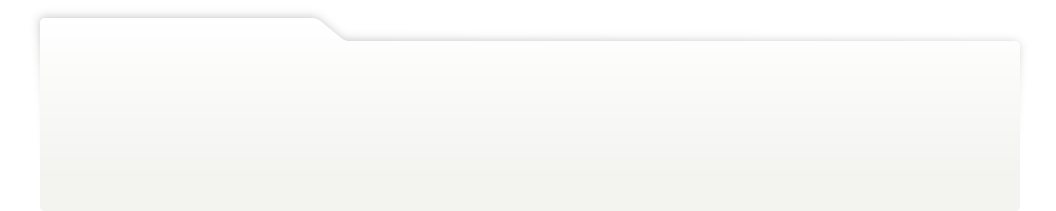
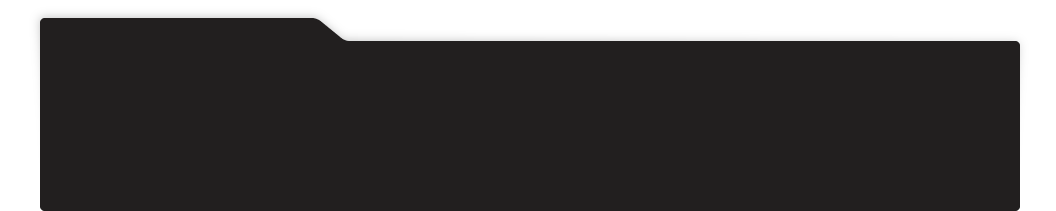
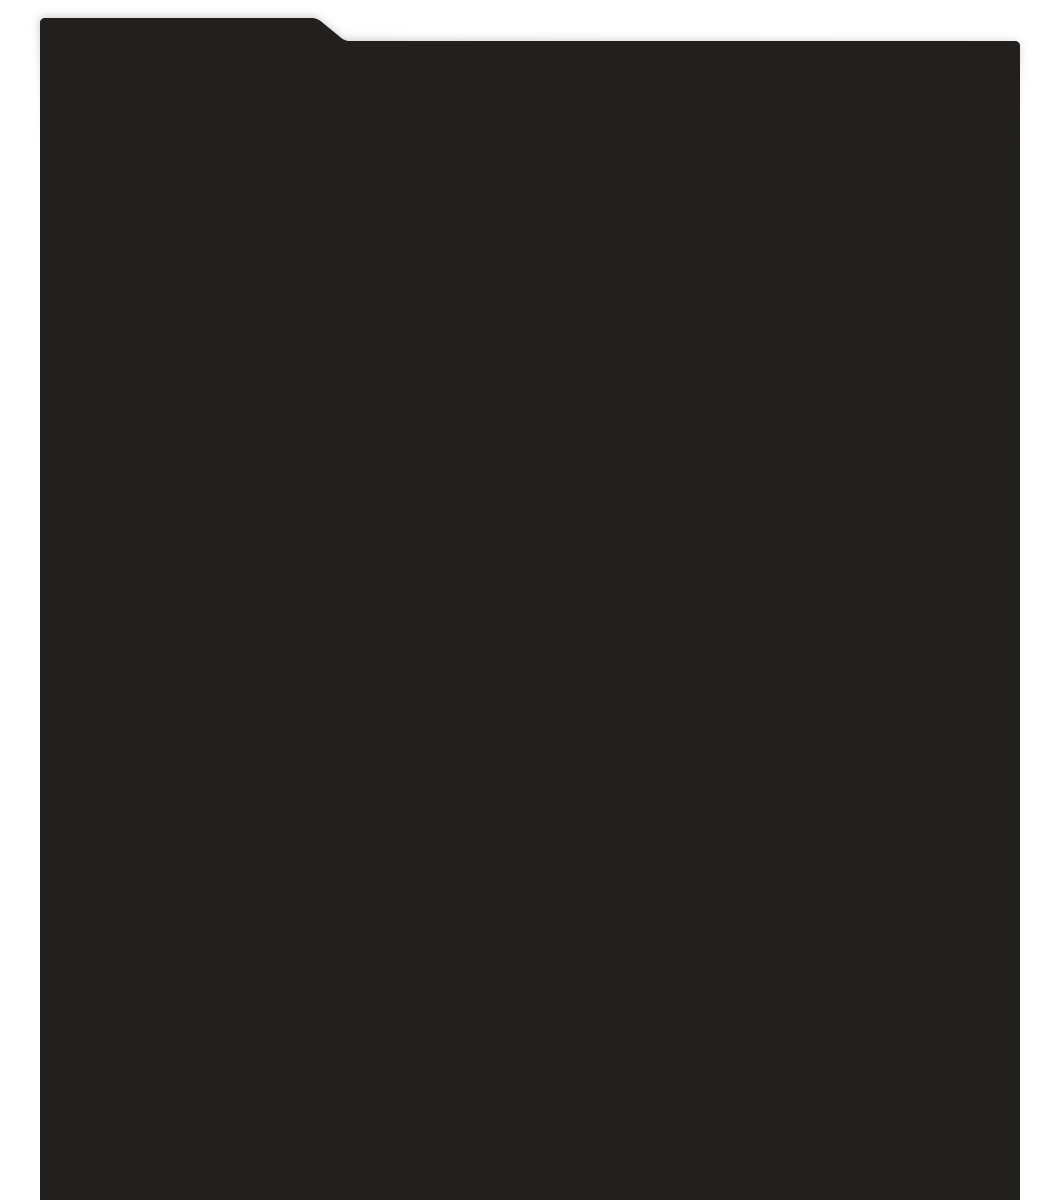
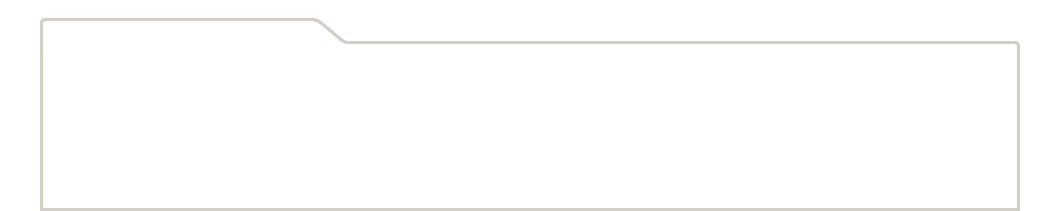
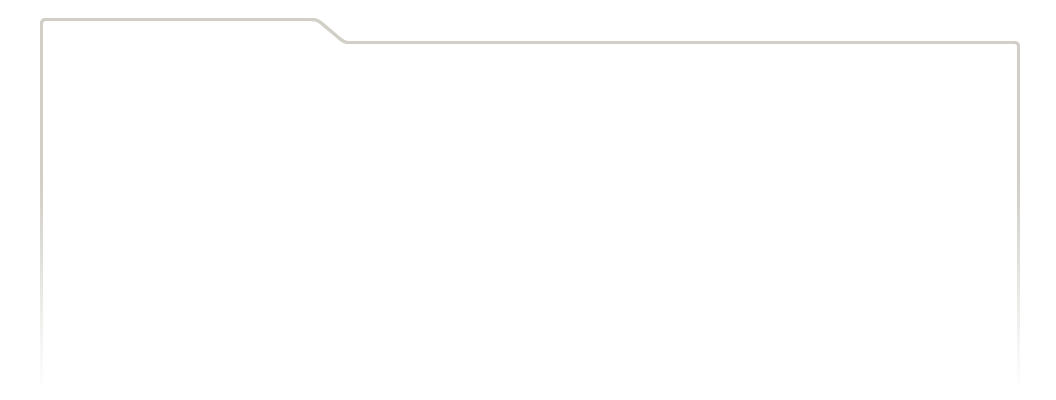
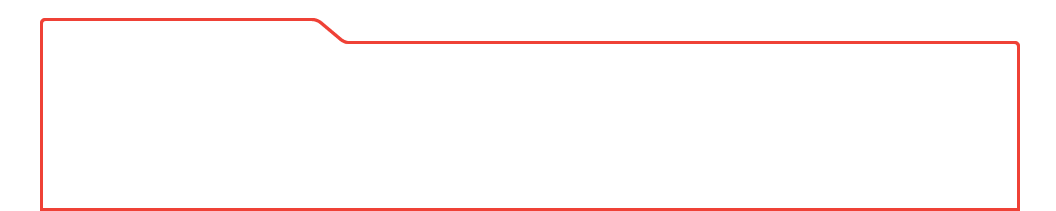
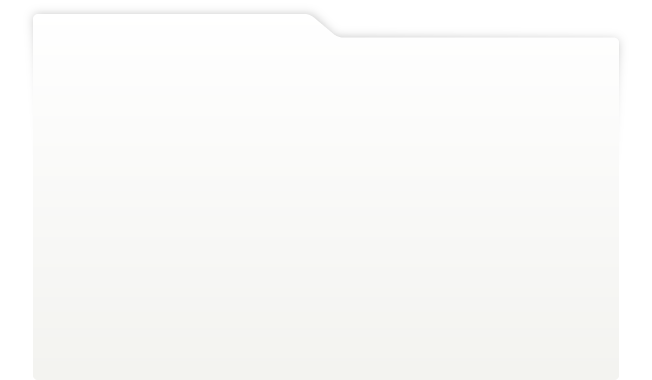
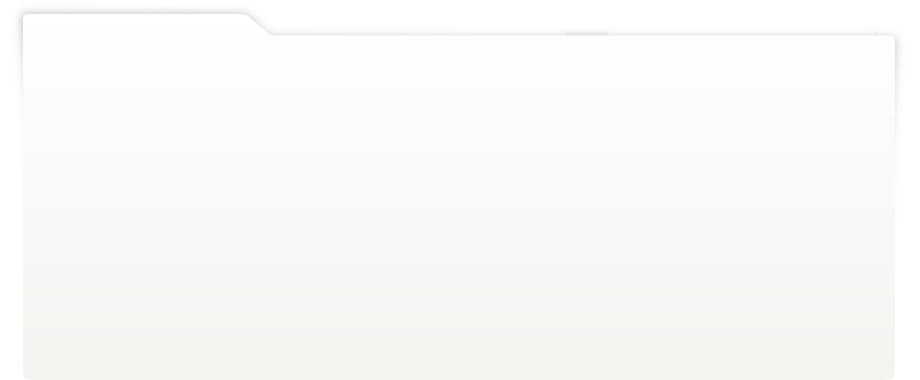
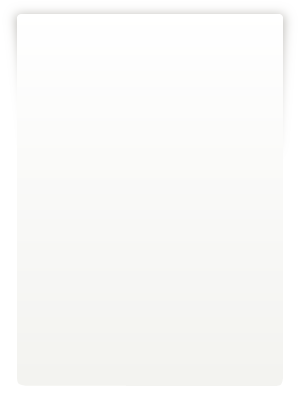
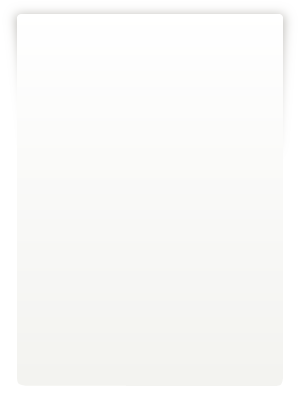
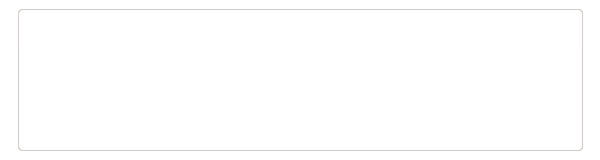
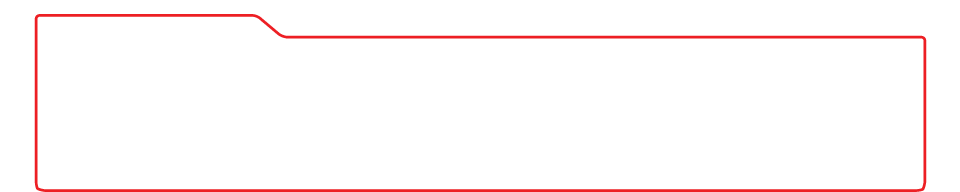
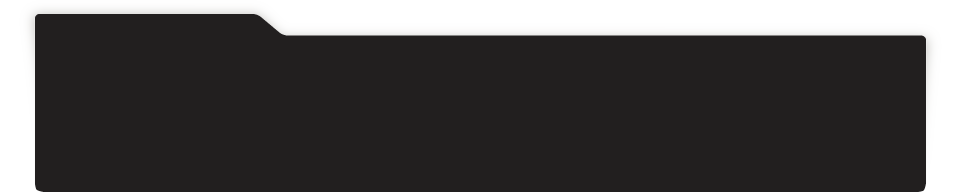
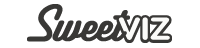
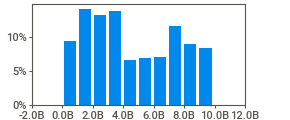
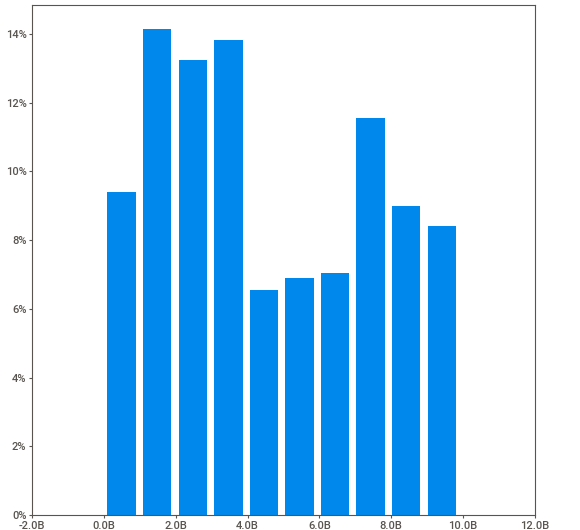
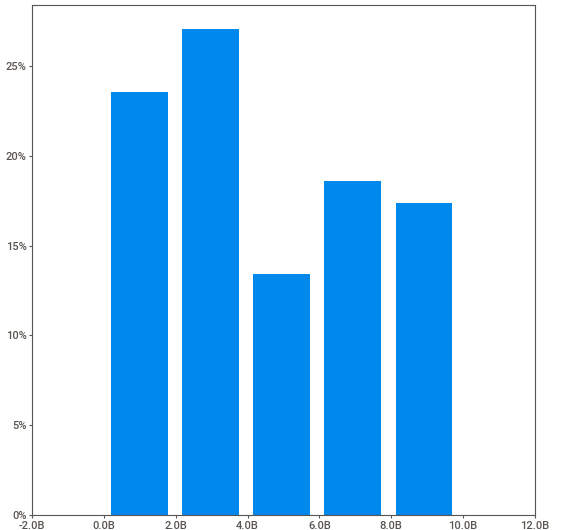
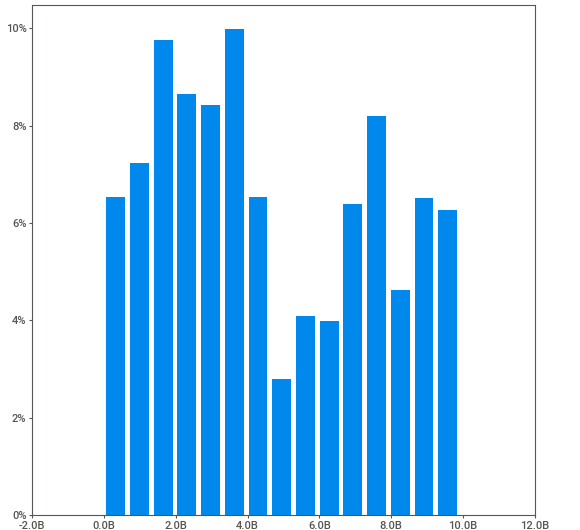
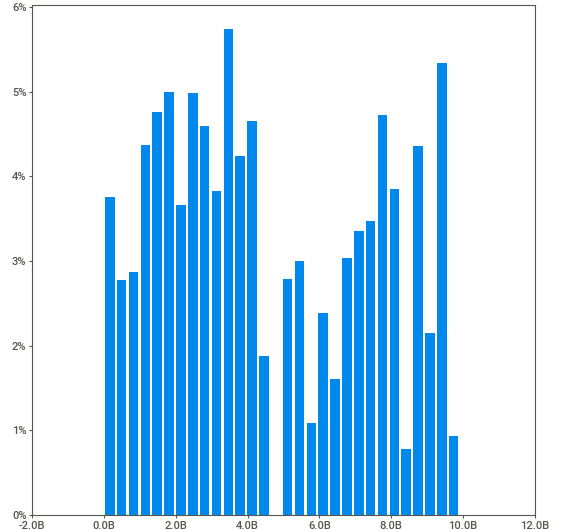
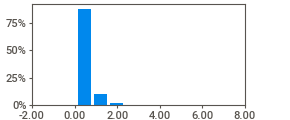
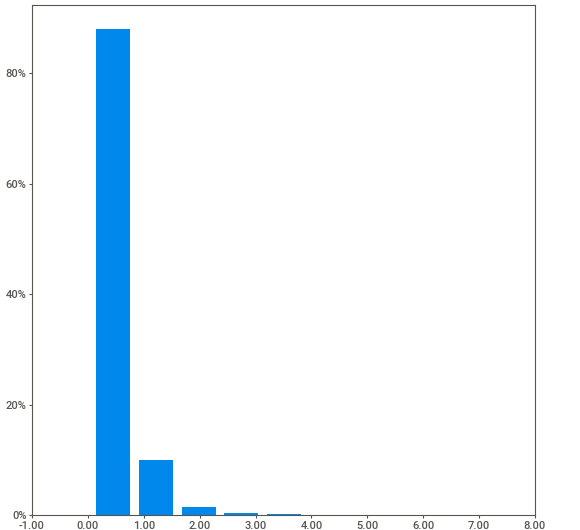
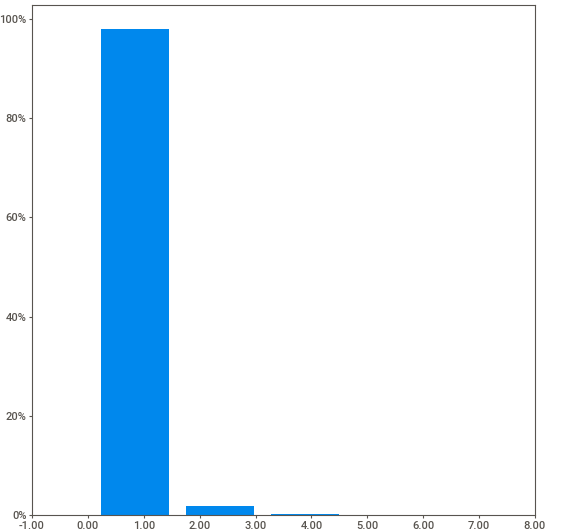
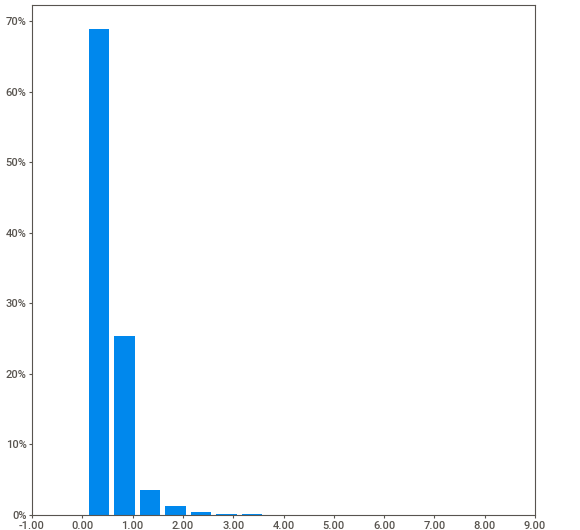
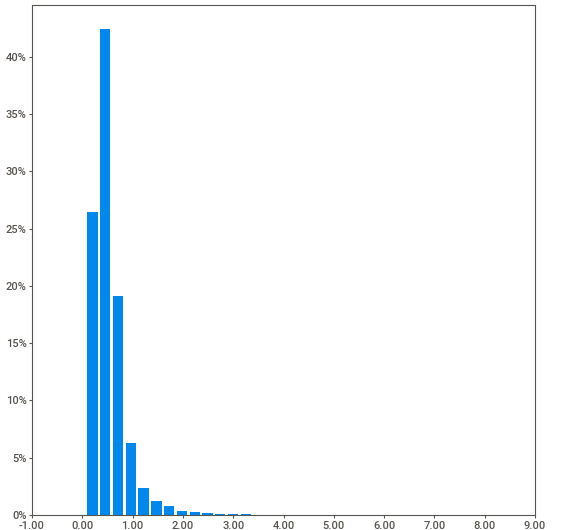
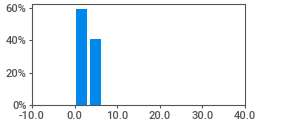
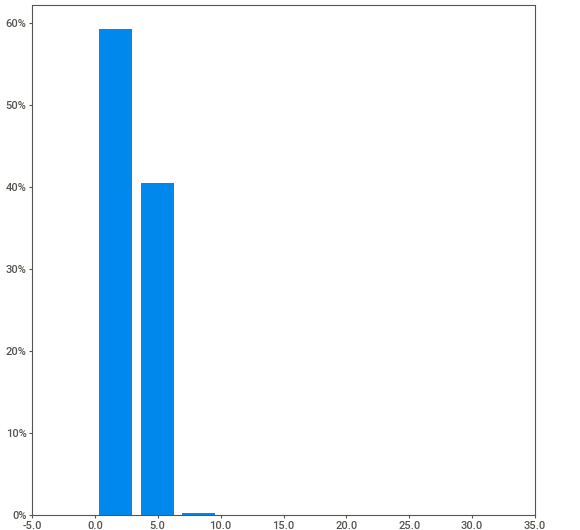
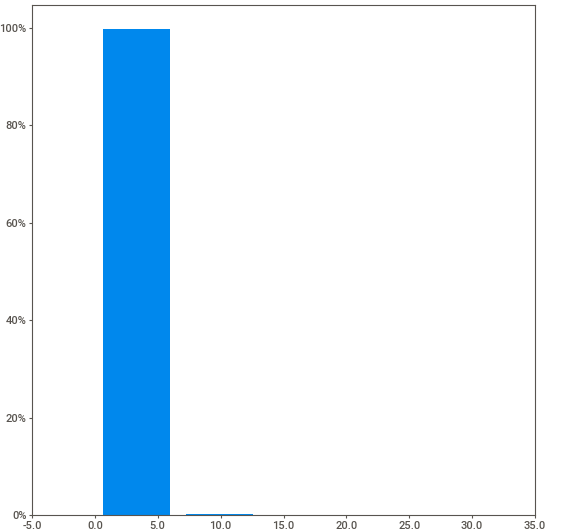
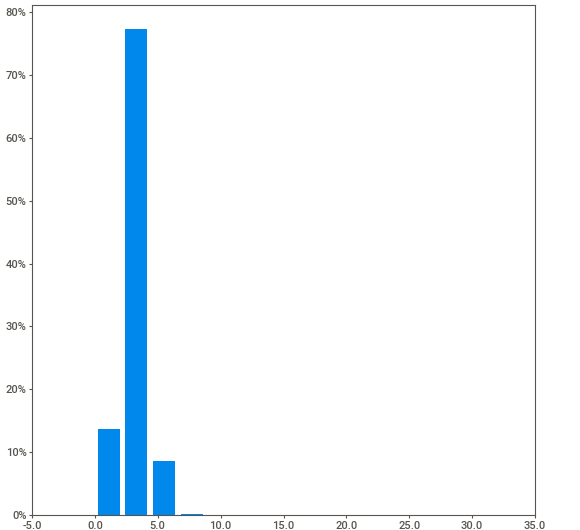
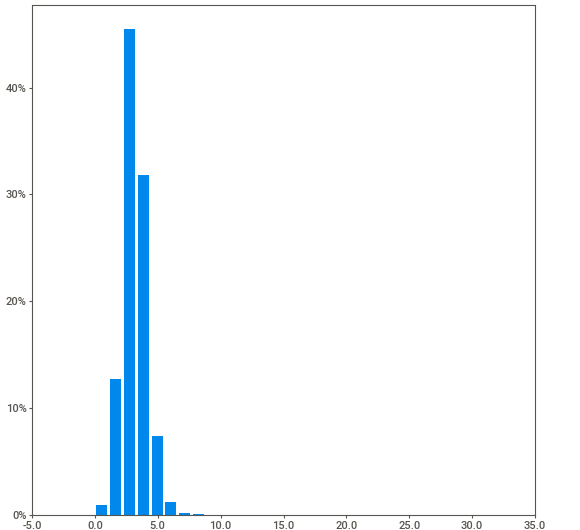
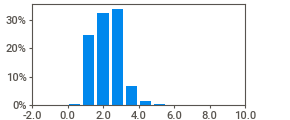
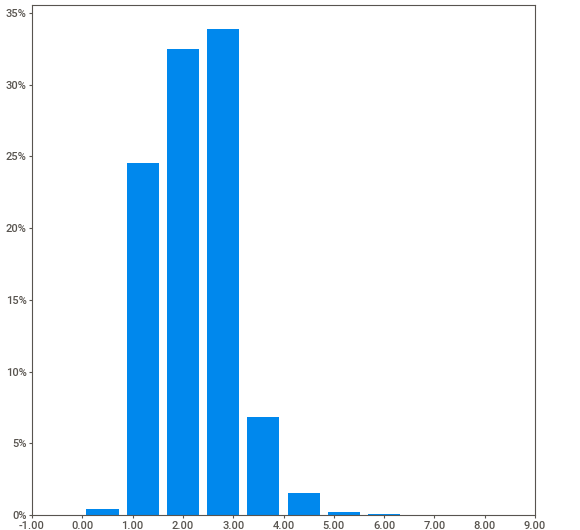
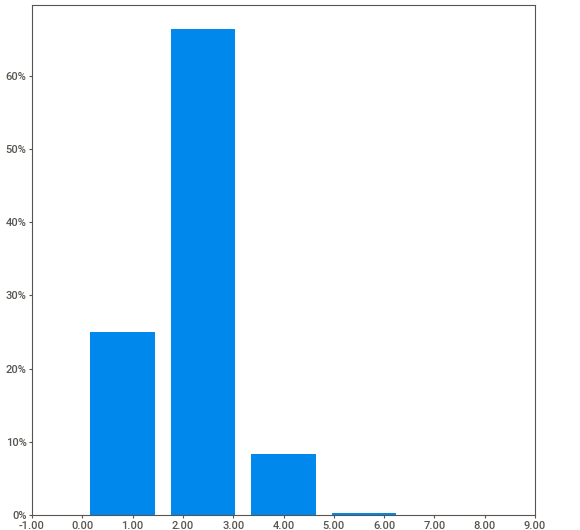
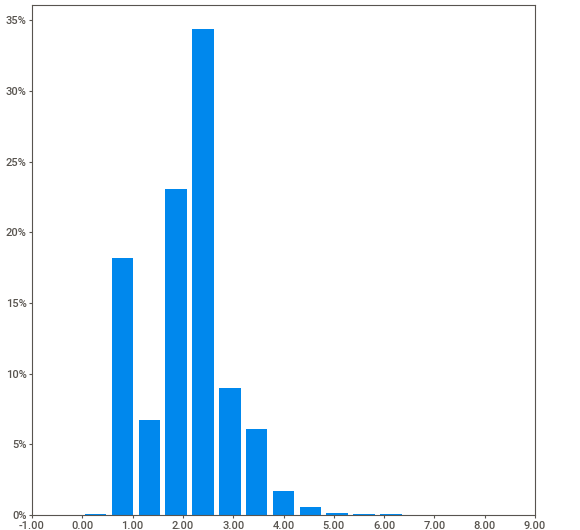
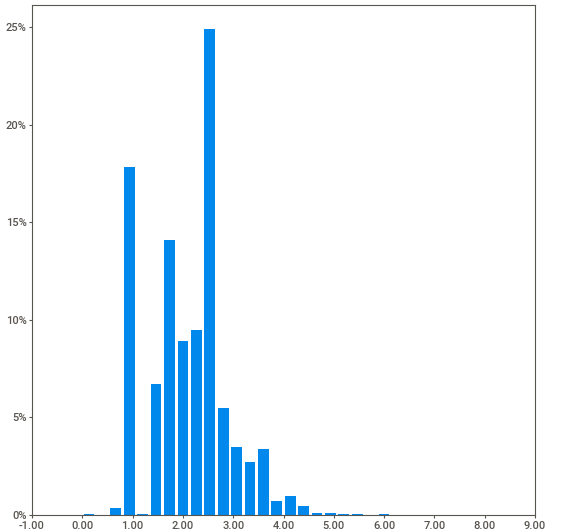
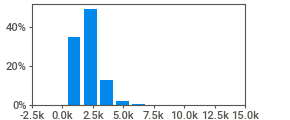
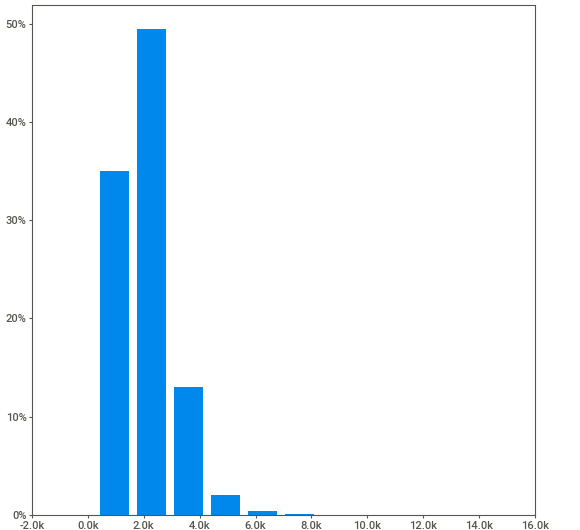
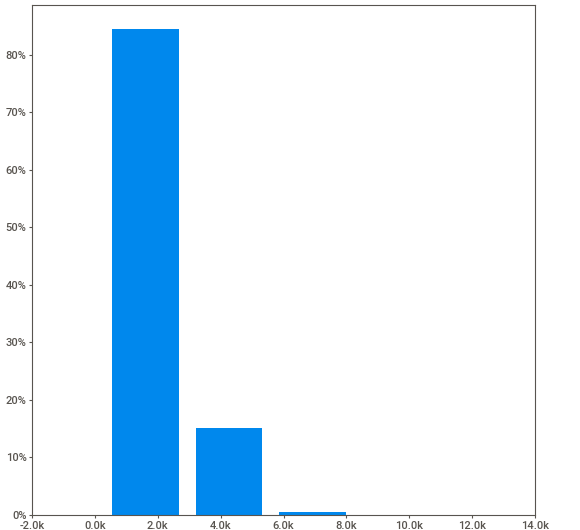
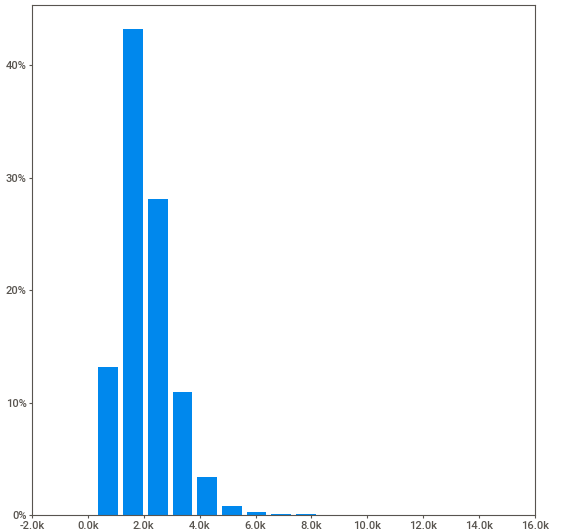
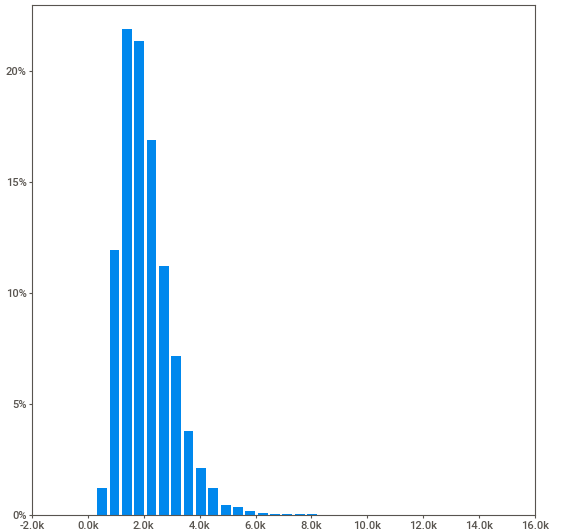
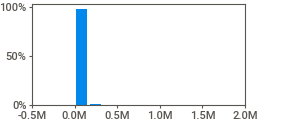
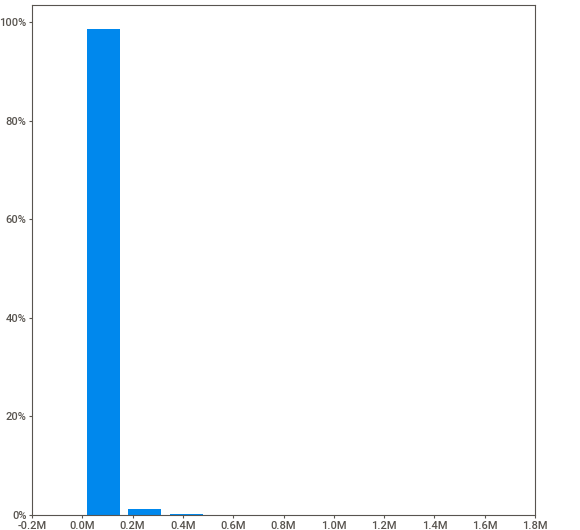
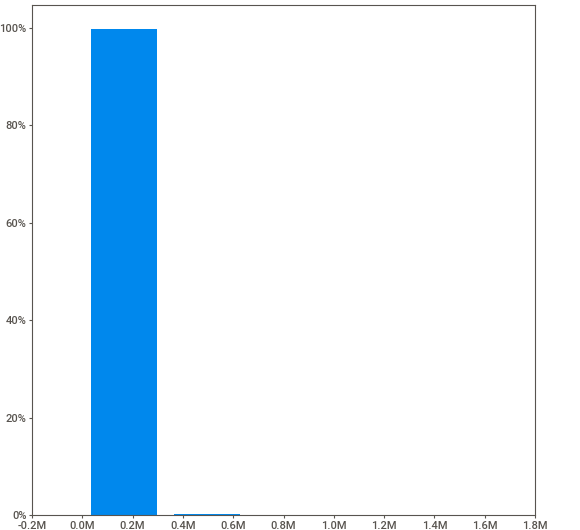
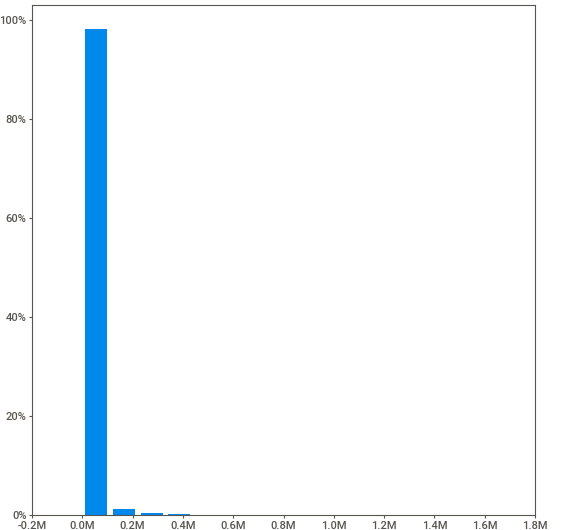
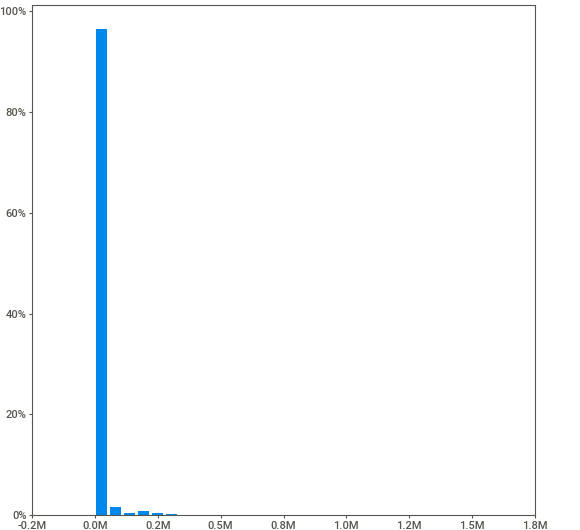
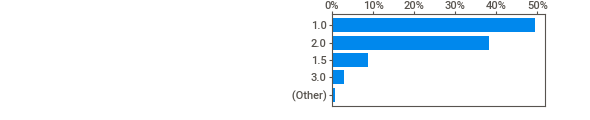
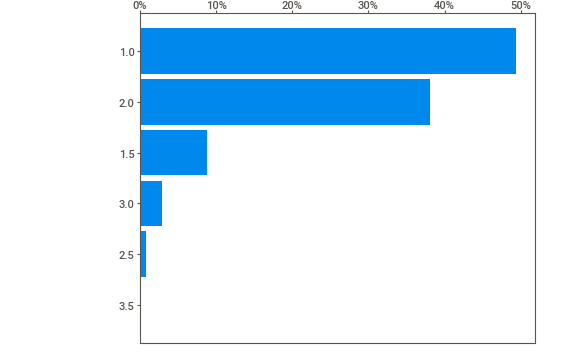
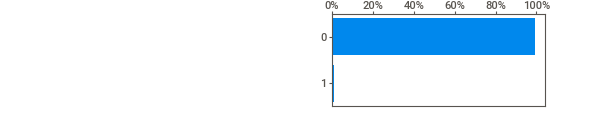
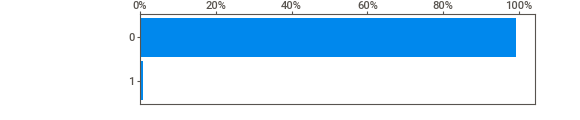
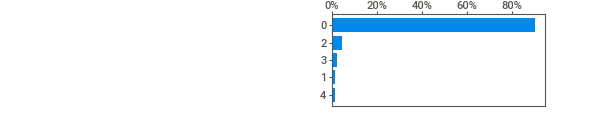
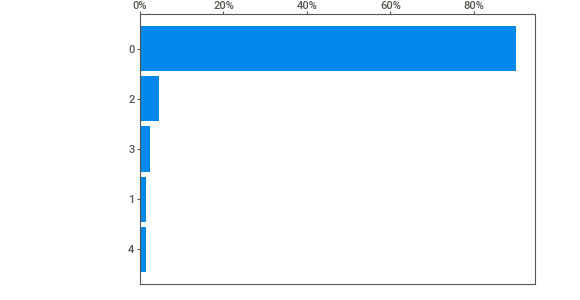
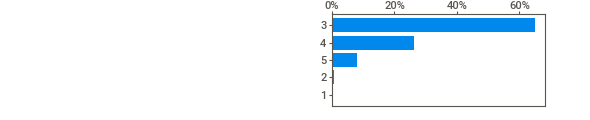
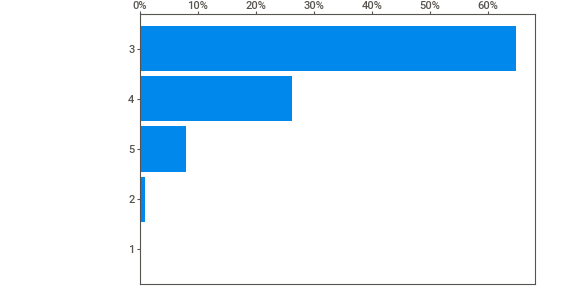
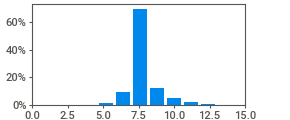
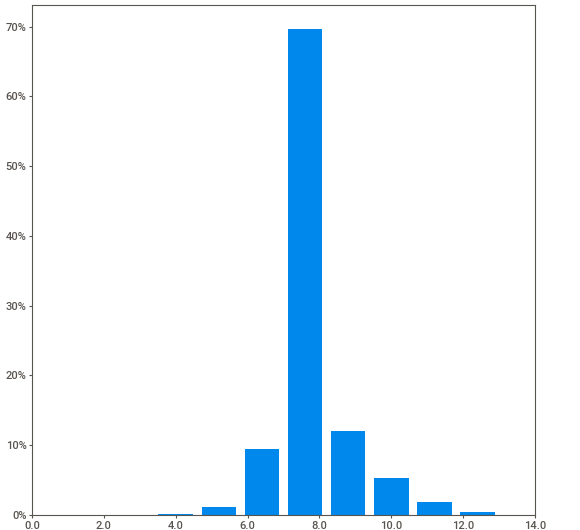
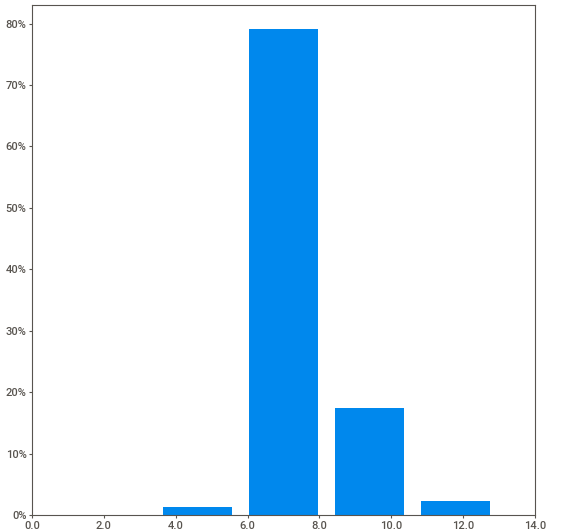
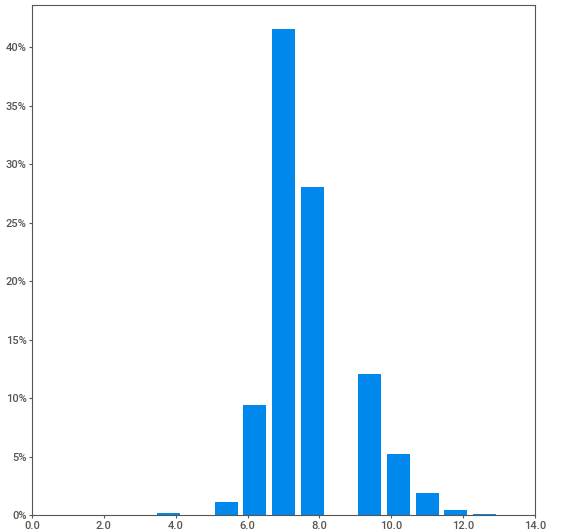
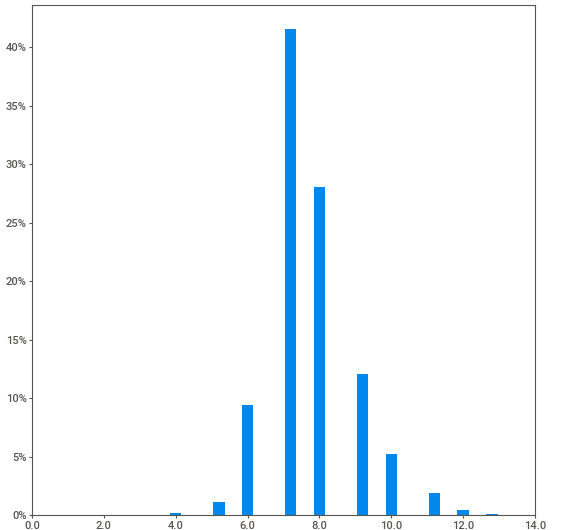
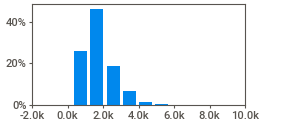
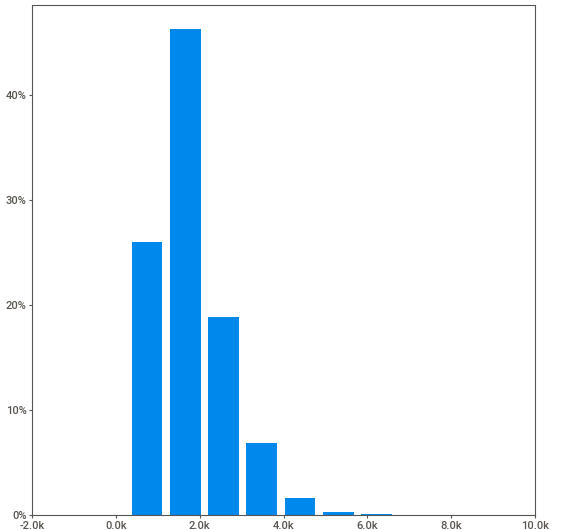
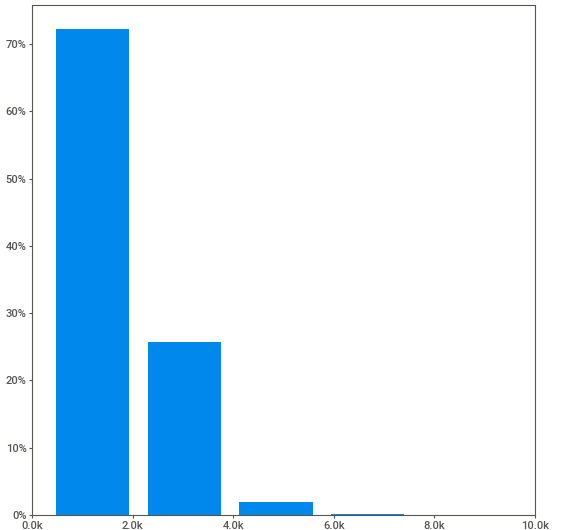
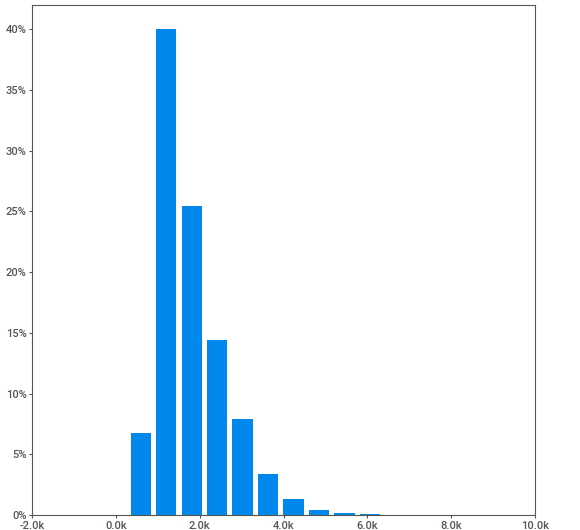
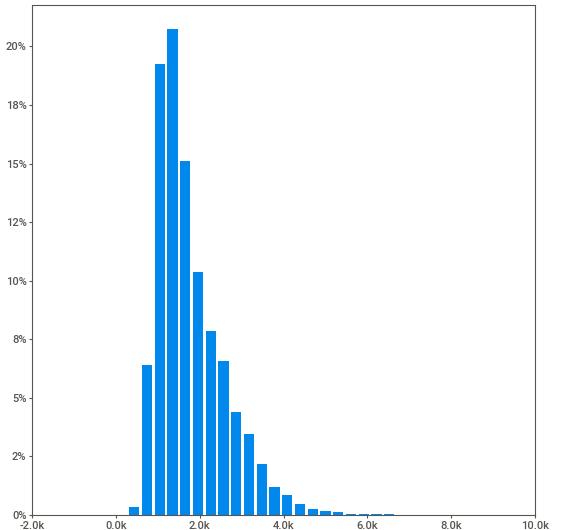
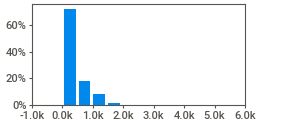
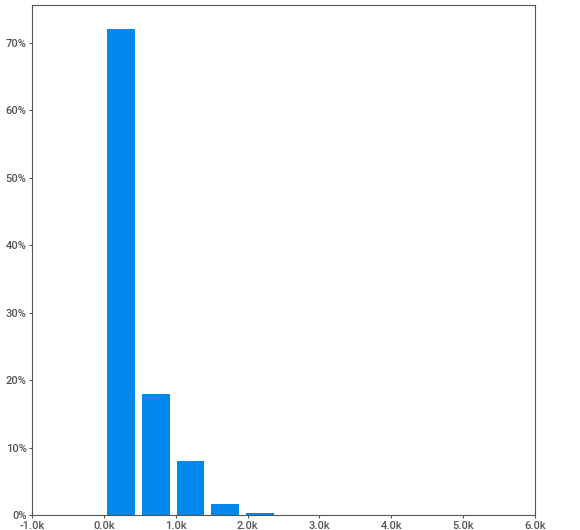
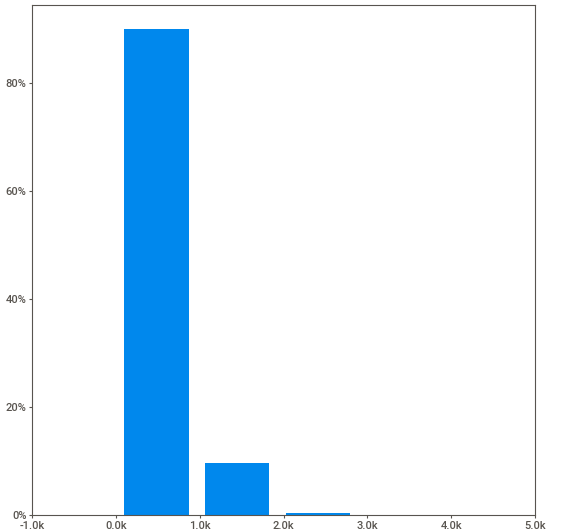
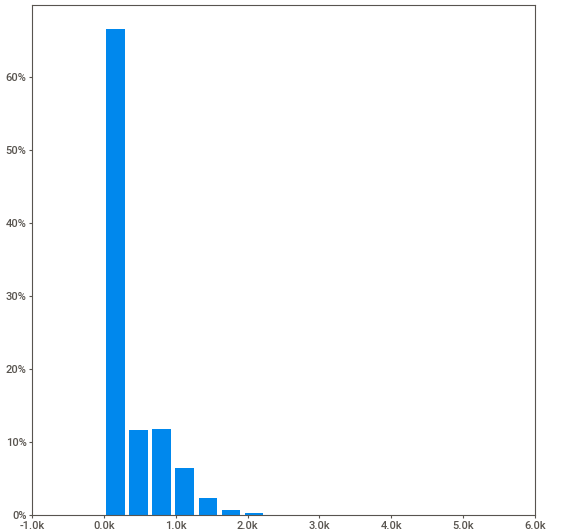
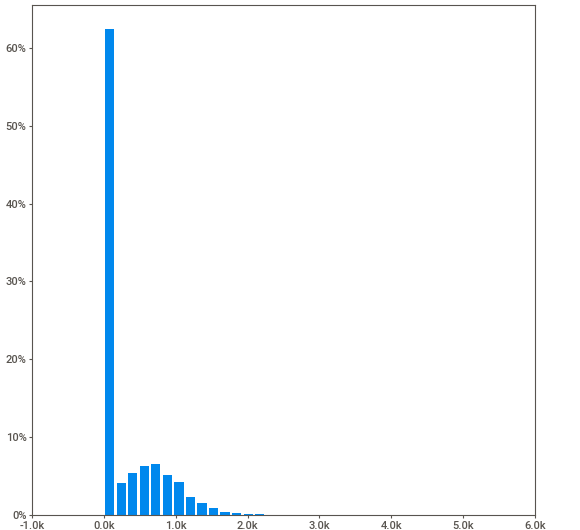
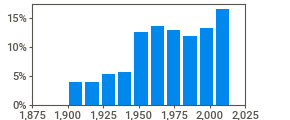
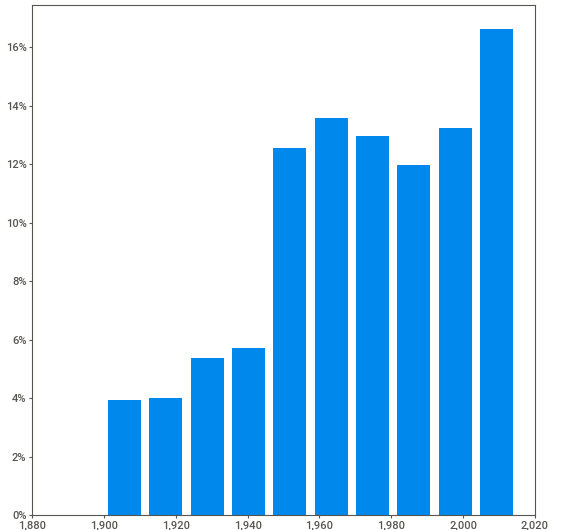
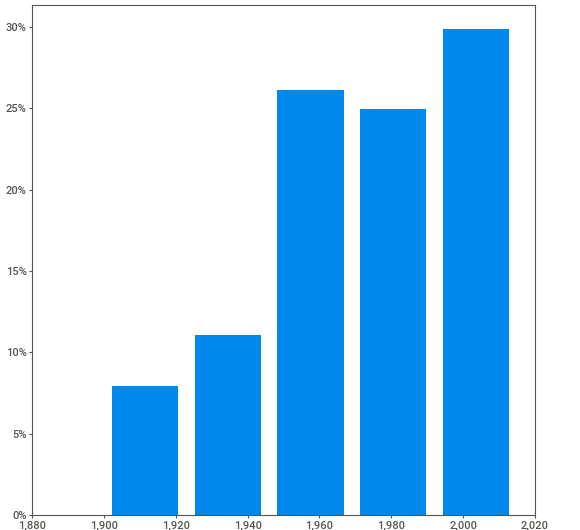
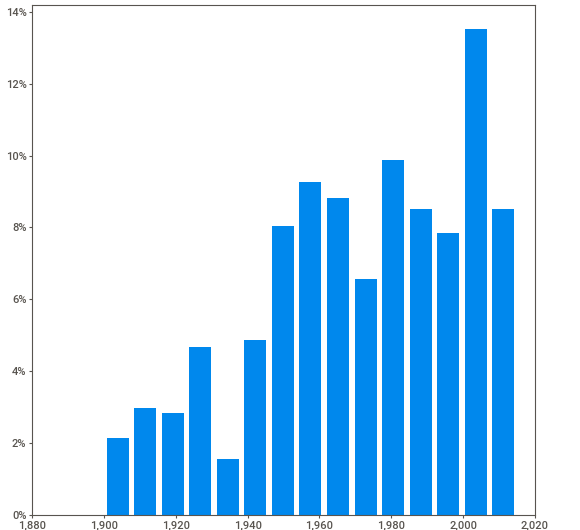
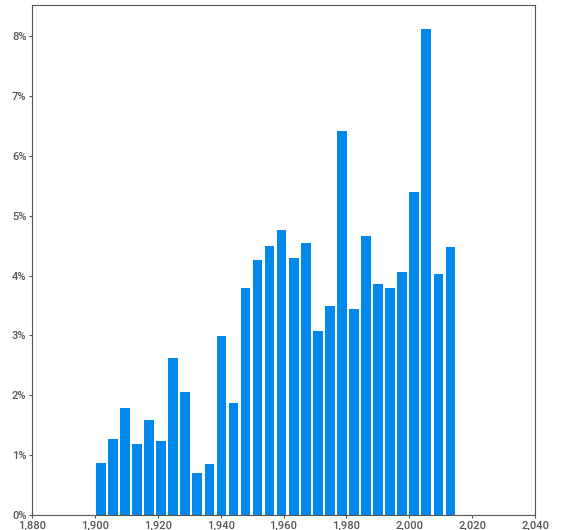
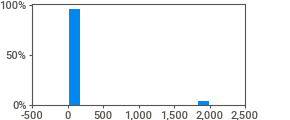
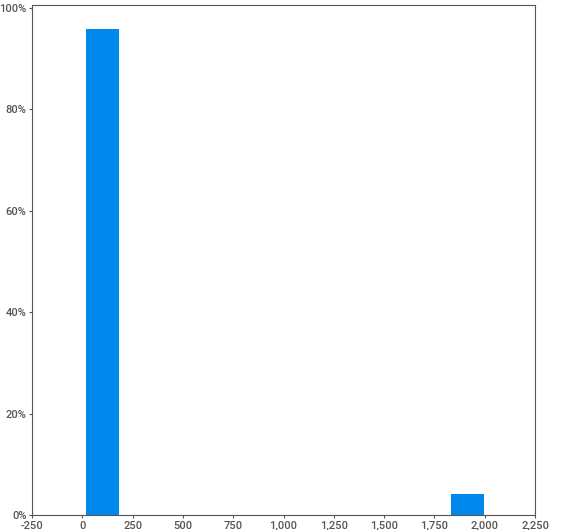
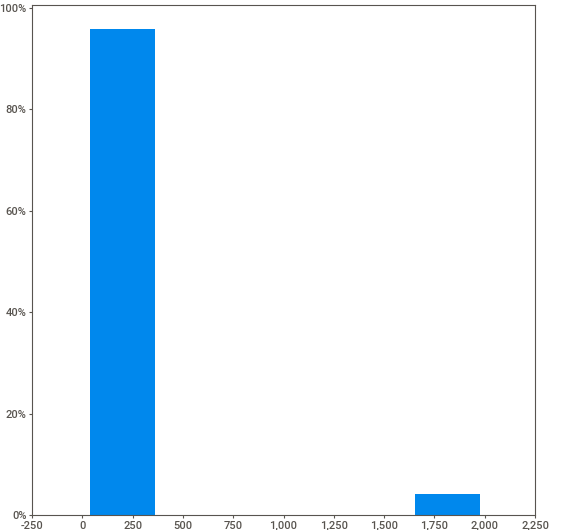
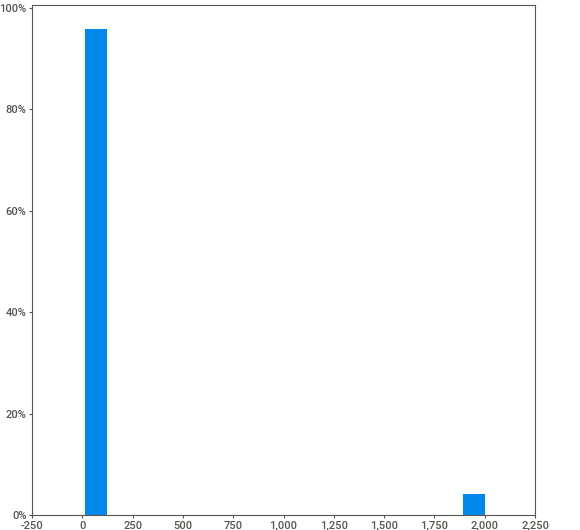
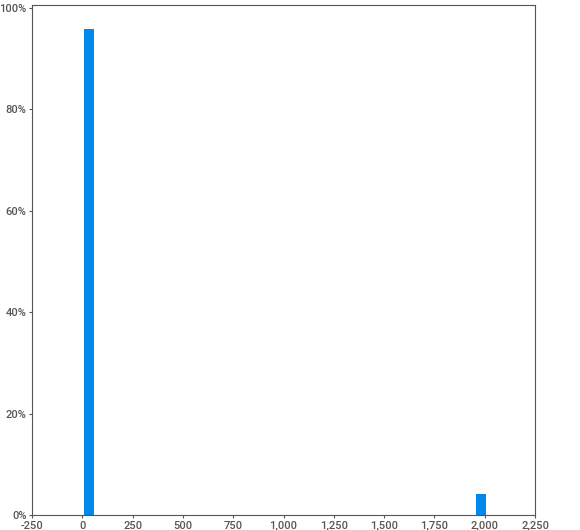
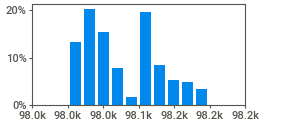
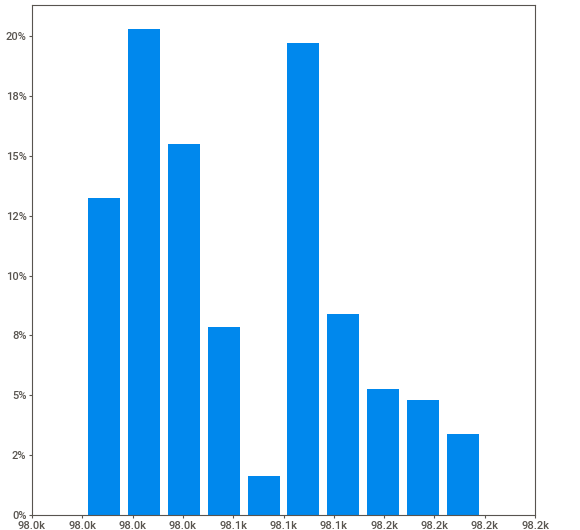
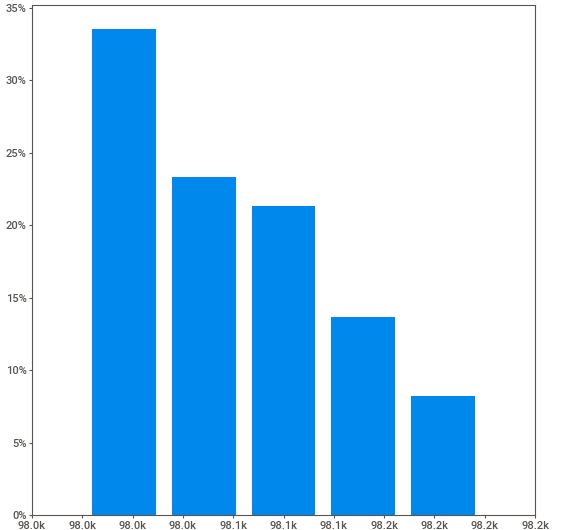
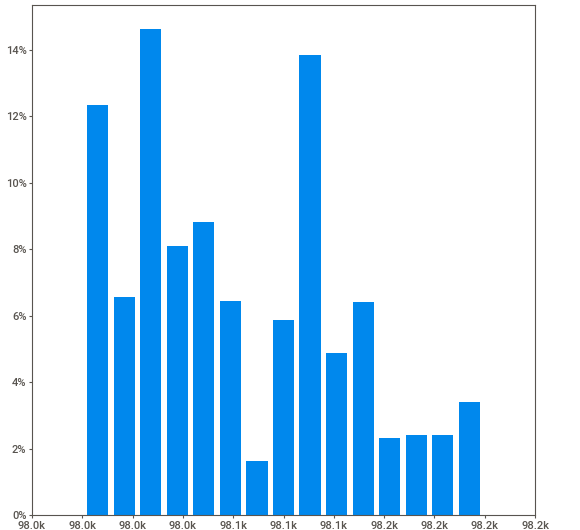
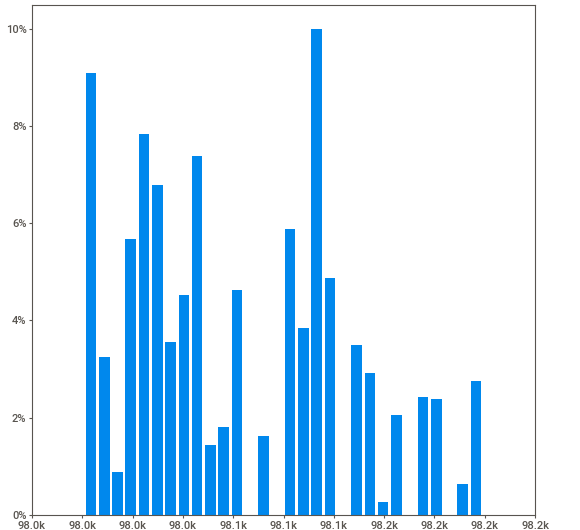
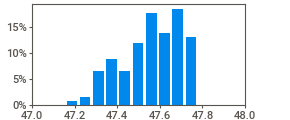
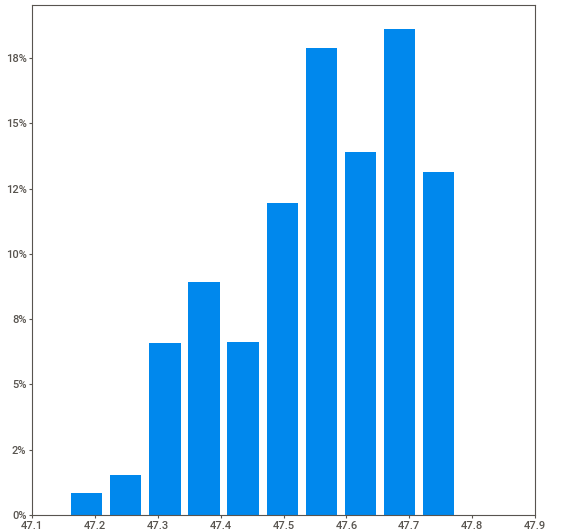
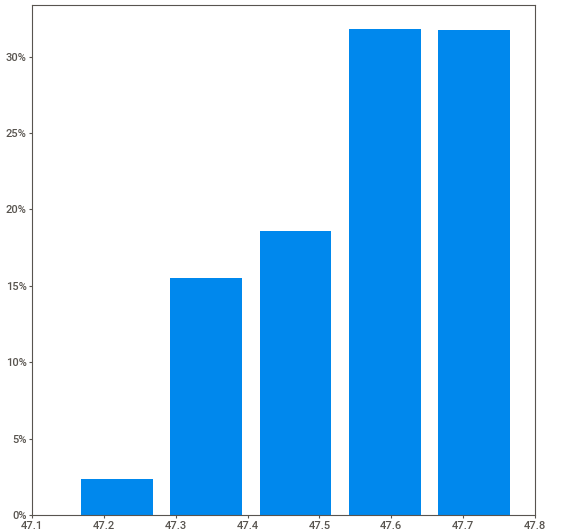
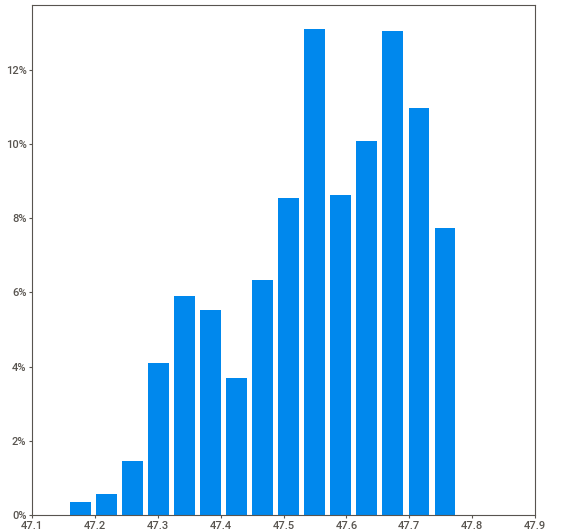
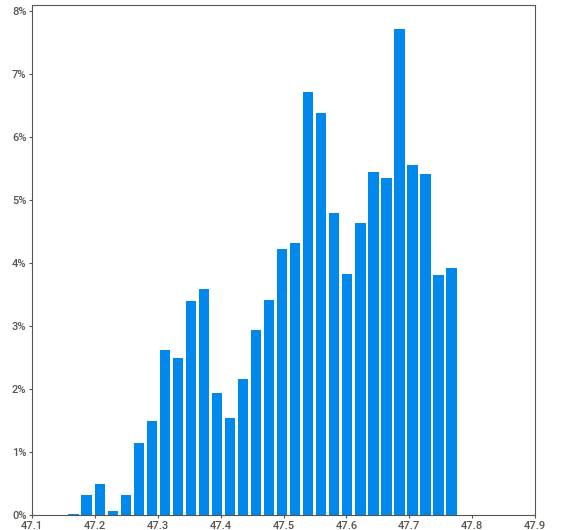
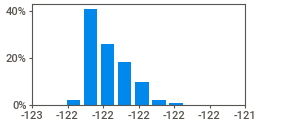
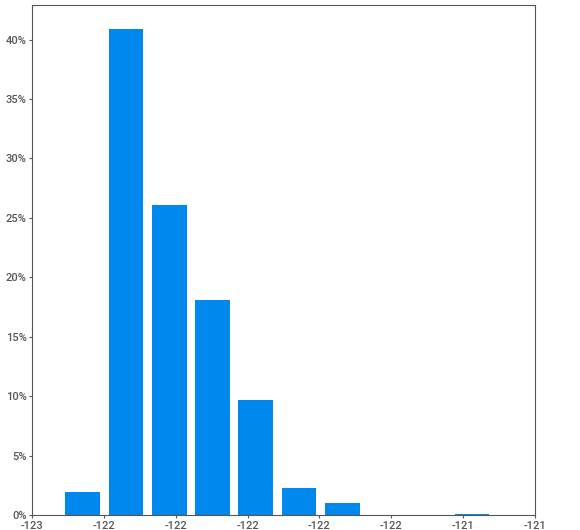
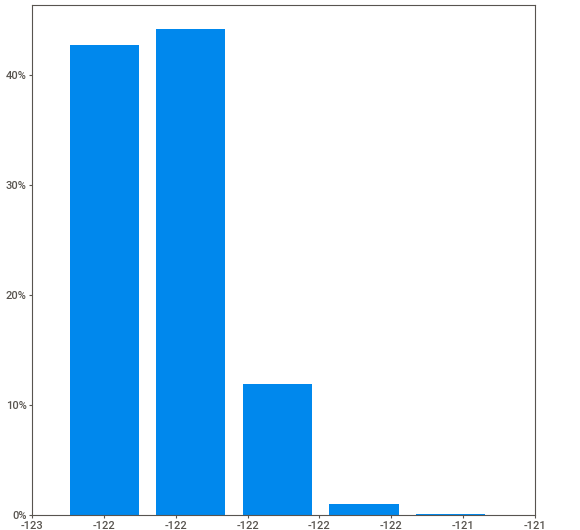
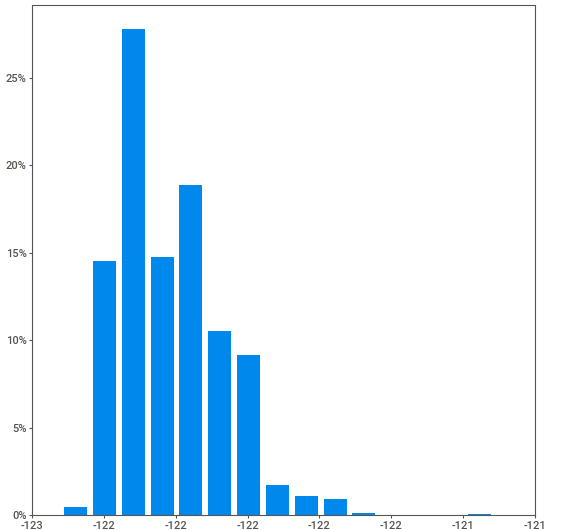
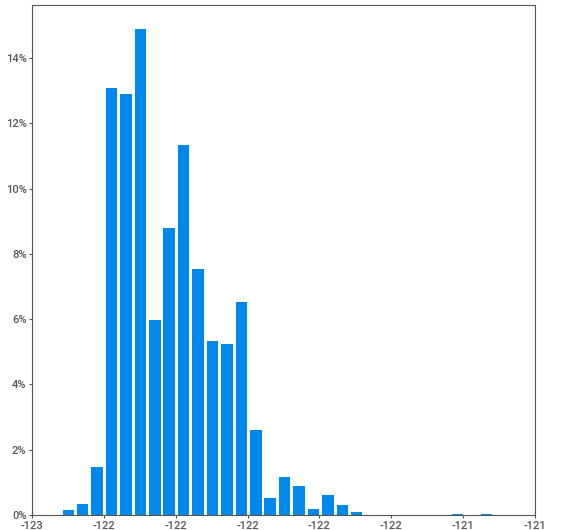
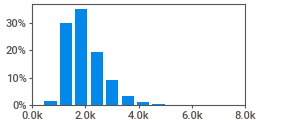
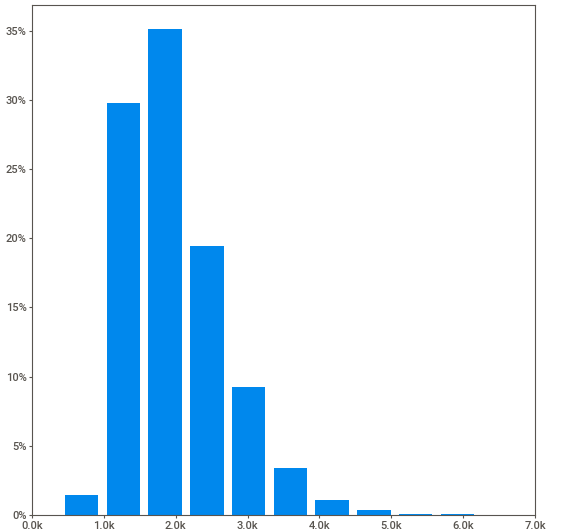
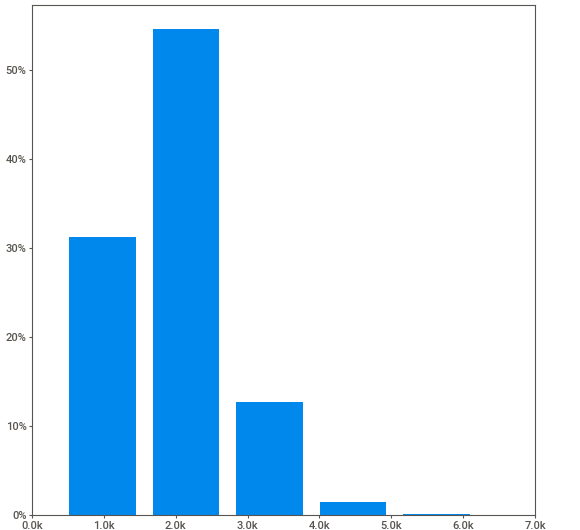
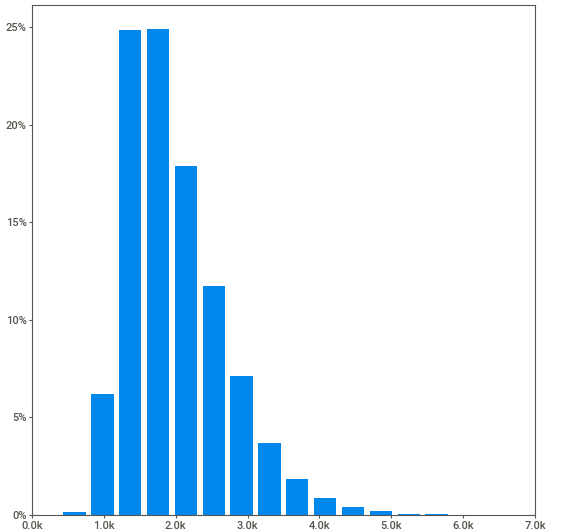
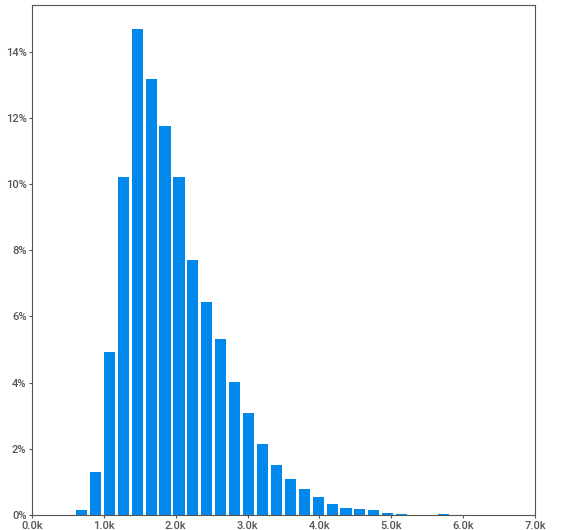
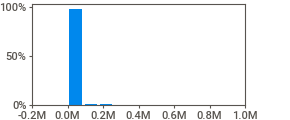
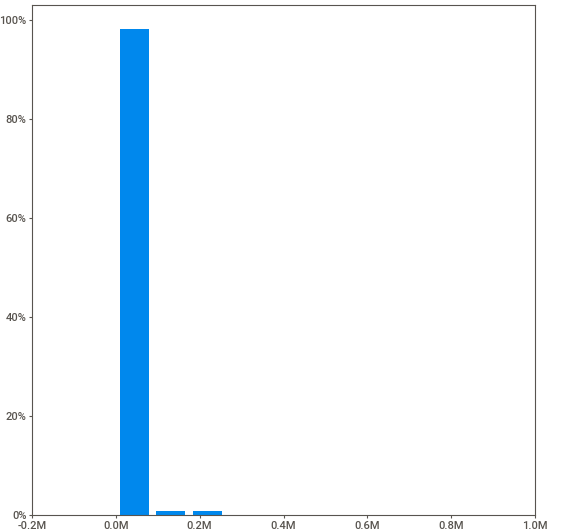
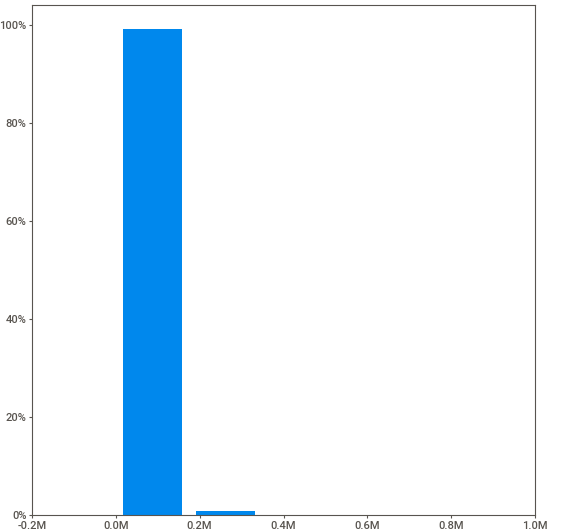
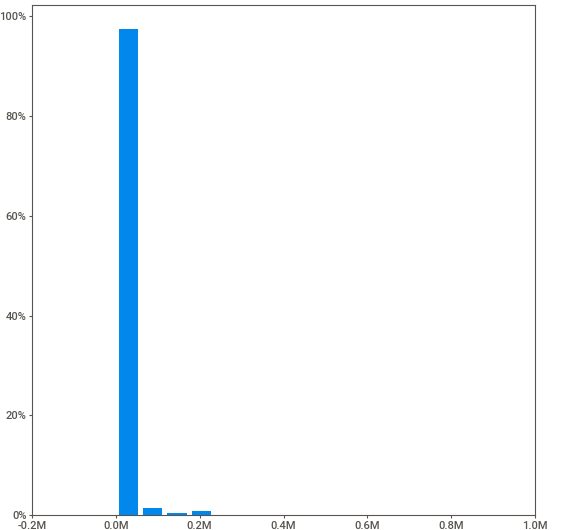
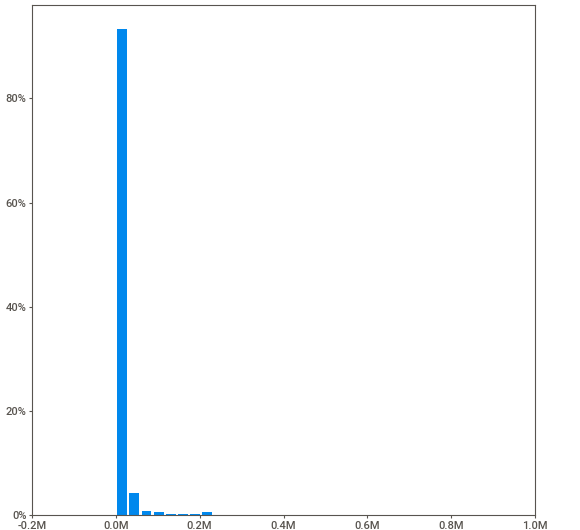
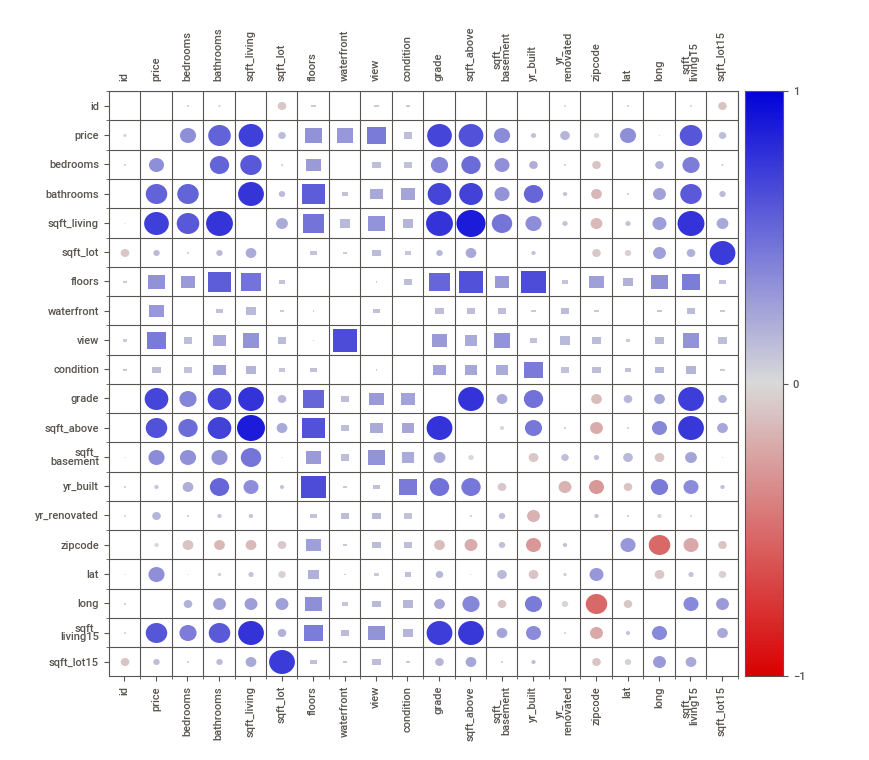
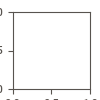

In [187]:
df = pd.read_csv('kc_house_data.csv')
df['price'] = df['price']/1000000
analysis = sv.analyze(df)
analysis.show_notebook()




Skewness: 4.021716
Kurtosis: 34.522444


/Users/alirezahosseini/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


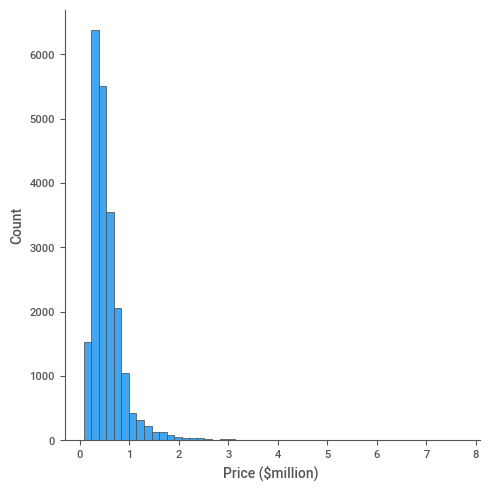

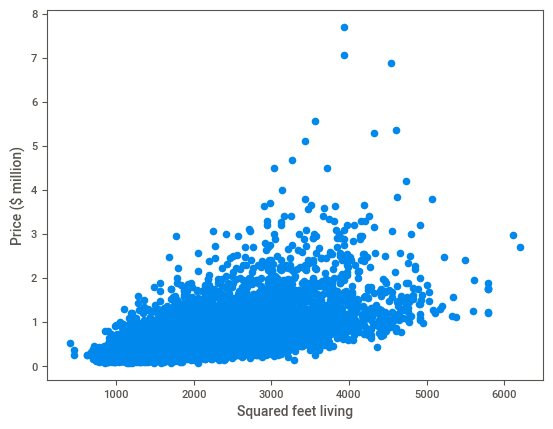

In [188]:
plot = sns.displot(df['price'], bins=50, kde=False)
plot.set_axis_labels('Price ($million) ')
print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())


data = pd.concat([df['price'], df['sqft_living15']], axis=1)
data.plot.scatter(x='sqft_living15', y='price')
plt.xlabel('Squared feet living')
plt.ylabel('Price ($ million)')
plt.show()



# Quick Take Away from Histogram, Price Distribution
- We can see most houses are somehwere between 0 to $1 million
- Price distribution has a correlation with Squared Feet Living, which is not that much strong

# Skewness
Skewness is a measure of the asymmetry of a distribution. A distribution is asymmetrical when its left and right side are not mirror images.
we have a skewness of ~ 4, meaning it is right-hand wing, that means data needs to be normalized.
# Kurtosis
Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution.
The Kurtosis is around 34 which is highly leptokurtic, meaning we have many outliers or large values, perhaps it is just a luxury indicator :)

Therefore, the key to a normal distribution could be using log !

Non-numeric columns: Index(['date'], dtype='object')


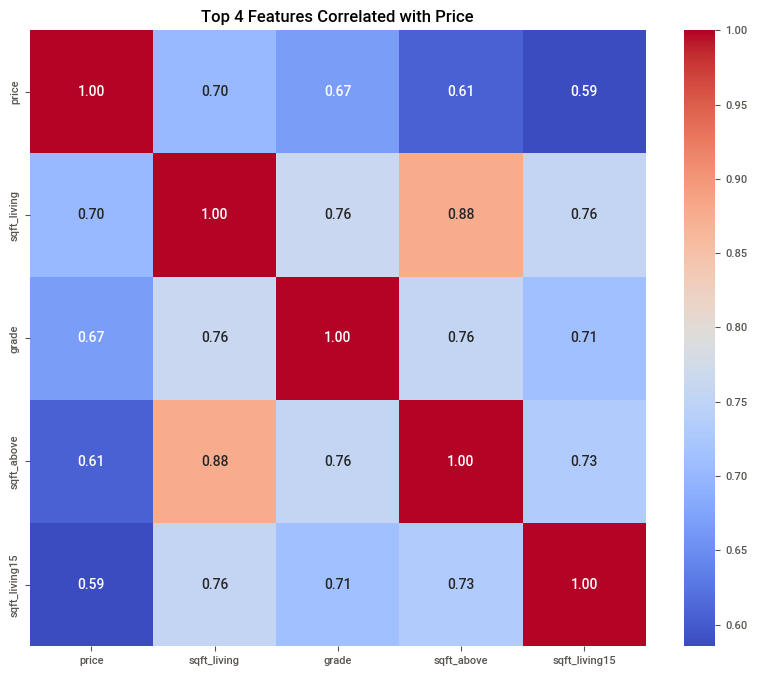

In [189]:

non_numeric_cols = df.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols)


# Correlation matrix
corrmat = df.select_dtypes(include=['number']).corr()

cols = corrmat.nlargest(5, 'price')['price'].index
cm = np.corrcoef(df[cols].values.T)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
            yticklabels=cols.values, xticklabels=cols.values, cmap="coolwarm")
plt.title('Top 4 Features Correlated with Price')
plt.show()



outer range (low) of the distribution:
[[-1.26630579]
 [-1.25813927]
 [-1.25269493]
 [-1.24997276]
 [-1.24725059]
 [-1.2458895 ]
 [-1.24452841]
 [-1.24180624]
 [-1.23908407]
 [-1.23908407]]

outer range (high) of the distribution:
[[10.75208304]
 [10.77930476]
 [11.24207398]
 [12.4398296 ]
 [12.95704226]
 [13.09315085]
 [13.69202866]
 [17.28529554]
 [17.74806476]
 [19.49025476]]


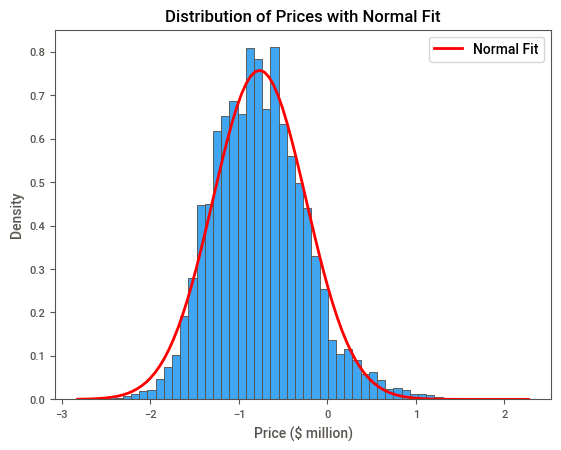

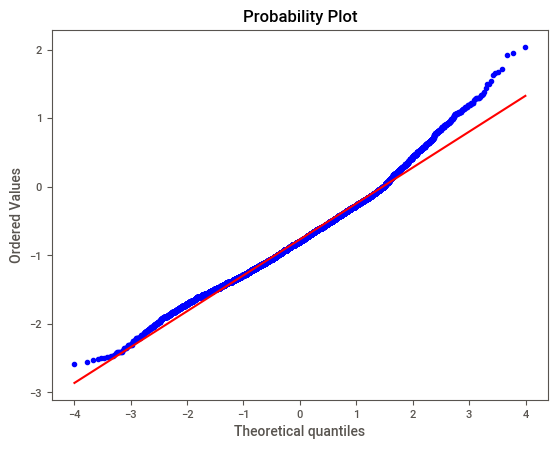

Outer range (low) of the distribution:
[-1.94889094 -1.86178479 -1.85089652 -1.84654122 -1.84000825 -1.84000825
 -1.81823172 -1.80734345 -1.80734345 -1.79645518]

Outer range (high) of the distribution:
[ 6.44596429  6.45685256  6.46774083  7.1754783   7.75255654  8.23164037
  8.50384709  8.66717112 10.85571315 12.4780652 ]


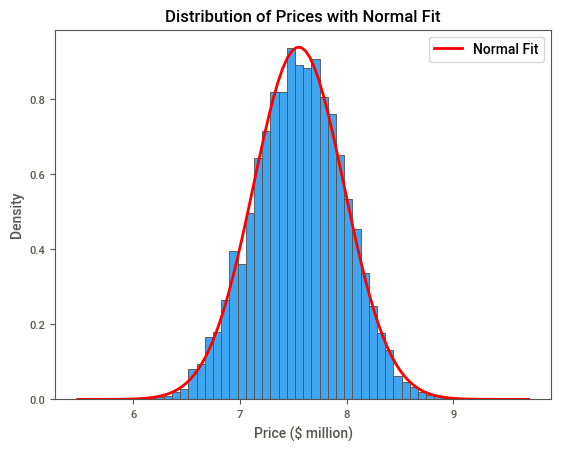

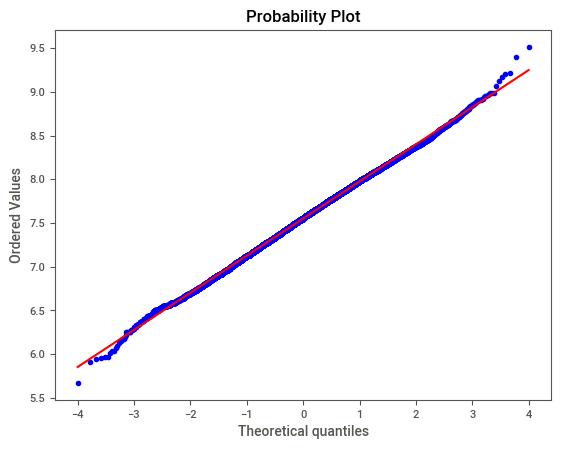

In [190]:
## Standardizing the data <==> Price

scaled_price = preprocessing.StandardScaler().fit_transform(df['price'].values.reshape(-1,1));
low_range = scaled_price[scaled_price[:,0].argsort()][:10]
high_range= scaled_price[scaled_price[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)



df['price'] = np.log(df['price'])


sns.histplot(df['price'], bins=50, kde=False, stat="density")
xmin, xmax = plt.xlim() 
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, df['price'].mean(), df['price'].std())

plt.plot(x, p, 'r', linewidth=2, label="Normal Fit")
plt.xlabel("Price ($ million)")
plt.ylabel("Density")
plt.title("Distribution of Prices with Normal Fit")
plt.legend()
plt.show()
fig = plt.figure()
res = sp.stats.probplot(df['price'], plot = plt)
plt.show()

# Standardizing the data
scaler = StandardScaler()
df['scaled_sqft_living'] = scaler.fit_transform(df[['sqft_living']])

# Selecting lowest and highest 10 values
sorted_values = np.sort(df['scaled_sqft_living'])
low_range = sorted_values[:10]
high_range = sorted_values[-10:]

print('Outer range (low) of the distribution:')
print(low_range)
print('\nOuter range (high) of the distribution:')
print(high_range)

# # going to log nature <==> sqft_living
df['sqft_living'] = np.log(df['sqft_living'])

sns.histplot(df['sqft_living'], bins=50, kde=False, stat="density")
xmin, xmax = plt.xlim() 
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, df['sqft_living'].mean(), df['sqft_living'].std())

plt.plot(x, p, 'r', linewidth=2, label="Normal Fit")
plt.xlabel("Price ($ million)")
plt.ylabel("Density")
plt.title("Distribution of Prices with Normal Fit")
plt.legend()
plt.show()
fig = plt.figure()
res = sp.stats.probplot(df['sqft_living'], plot = plt)
plt.show()





In [191]:
# separating price from other features as the target
price = df.price.values

features_names = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','view', 'condition', 'grade', 'sqft_above',
                  'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long','sqft_living15', 'sqft_lot15']
features=df[features_names]

X_train, X_test, y_train, y_test = train_test_split(features, price, test_size=0.2, random_state=42)

lreg = LinearRegression()
lreg.fit(X_train,y_train)

r2 = r2_score(y_test,lreg.predict(X_test))

accuracy = lreg.score(X_test, y_test)
a = "Accuracy = {}%".format(int(round(accuracy * 100)))
print('R\u00b2' + "" + '=' + " " + str(r2))
print("")
print(a)
print("")
print('=========================================================')

for i in range(len(lreg.coef_)):
    print(features_names[i] + "" + '=' + "  " + str(lreg.coef_[i]))





R²= 0.7726643261285262

Accuracy = 77%

bedrooms=  -0.021550575754538177
bathrooms=  0.07005431295979304
sqft_living=  0.19092022436682934
sqft_lot=  4.08306404793984e-07
floors=  0.07019109706880809
view=  0.08057596302004122
condition=  0.058591147468340536
grade=  0.15343216375391797
sqft_above=  7.134950341720138e-05
sqft_basement=  7.37663562270877e-05
yr_built=  -0.0035871181943348063
yr_renovated=  3.7281658420557995e-05
zipcode=  -0.0006233514531780258
lat=  1.4019443479009286
long=  -0.1499988446608474
sqft_living15=  9.142990131080627e-05
sqft_lot15=  -1.8185510962955378e-07


In [138]:
def uncertainty(estimator, X_tr, X_te, y_tr, y_te):
    prediction_tr = estimator.predict(X_tr)
    
    print('')
    print('Estimator details')
    print('------------------------------------------')
    print(estimator)
    
    def get_score(prediction, lables):    
        print('R\u00b2: {}'.format(r2_score(prediction, lables)))
        print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))
    
    
    
    print('')
    print("Error Values for Train Set")
    print('------------------------------------------')
    get_score(prediction_tr, y_tr)
    
    
    print('')
    print("Error Values for Test Set")
    print('------------------------------------------')
    prediction_test = estimator.predict(X_te)
    get_score(prediction_test, y_te)

# let's do default to see what will happen

Gradient_Boosting = GB(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber').fit(X_train, y_train)

uncertainty(Gradient_Boosting, X_train, X_test, y_train, y_test)

print('')
print('')
print("Gradient Boosting Model Accuracy")
print('------------------------------------------')
scores = cross_val_score(Gradient_Boosting, X_test, y_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



Estimator details
------------------------------------------
GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_features='sqrt',
                          min_samples_leaf=15, min_samples_split=10,
                          n_estimators=3000)

Error Values for Train Set
------------------------------------------
R²: 0.9227076069352991
RMSE: 0.138392715749681

Error Values for Test Set
------------------------------------------
R²: 0.8957315434897313
RMSE: 0.1641998975695904


Gradient Boosting Model Accuracy
------------------------------------------
Accuracy: 0.89 (+/- 0.03)


# Gradient Boosting Vs XGboost
Fundamentally, they are the same! However, XGboost can do calculations faster, and above all one can parallelize it.
This is especially an important feature when it comes to calculations in cloud computing environments. Furthermore, XGboost regularizes trees to prevent overfitting (overestimation), and it deals with the missing values efficiently as well.

Below, there is a hyperparameter tunning approach where Randomized Search is employed.


In [139]:
gb = GradientBoostingRegressor()

param_dist = {
    'n_estimators': np.arange(500, 5000, 500),
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'max_depth': np.arange(3, 10, 1),
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 10, 2),
    'max_features': ['sqrt', 'log2', None],  
    'subsample': np.linspace(0.5, 1.0, 5)
}

random_search = RandomizedSearchCV(gb, param_dist, n_iter=50, cv=5, scoring='r2', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

best_model = random_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print(f"Test R² Score: {test_score:.4f}")




Best Parameters: {'subsample': 0.5, 'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': 9, 'learning_rate': 0.01}
Test R² Score: 0.9054


# If we use Best Parameters, the accuracy of the model will be almost 91%.

[0]	train-rmse:0.34627	eval-rmse:0.34703
[1]	train-rmse:0.31370	eval-rmse:0.31563
[2]	train-rmse:0.29271	eval-rmse:0.29183
[3]	train-rmse:0.28240	eval-rmse:0.28062
[4]	train-rmse:0.26850	eval-rmse:0.27162
[5]	train-rmse:0.26256	eval-rmse:0.26391
[6]	train-rmse:0.25851	eval-rmse:0.26074
[7]	train-rmse:0.25423	eval-rmse:0.25998
[8]	train-rmse:0.25086	eval-rmse:0.25759
[9]	train-rmse:0.24847	eval-rmse:0.25455
[10]	train-rmse:0.24534	eval-rmse:0.25150
[11]	train-rmse:0.24260	eval-rmse:0.24825
[12]	train-rmse:0.23904	eval-rmse:0.24620
[13]	train-rmse:0.23625	eval-rmse:0.24229
[14]	train-rmse:0.23402	eval-rmse:0.23965
[15]	train-rmse:0.23265	eval-rmse:0.23790
[16]	train-rmse:0.23151	eval-rmse:0.23706
[17]	train-rmse:0.23056	eval-rmse:0.23542
[18]	train-rmse:0.22910	eval-rmse:0.23536
[19]	train-rmse:0.22773	eval-rmse:0.23468
[20]	train-rmse:0.22648	eval-rmse:0.23381
[21]	train-rmse:0.22565	eval-rmse:0.23301
[22]	train-rmse:0.21965	eval-rmse:0.22484
[23]	train-rmse:0.21789	eval-rmse:0.22280
[2

/Users/alirezahosseini/anaconda3/lib/python3.11/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[171]	train-rmse:0.16418	eval-rmse:0.17577
[172]	train-rmse:0.16410	eval-rmse:0.17567
[173]	train-rmse:0.16401	eval-rmse:0.17554
[174]	train-rmse:0.16392	eval-rmse:0.17560
[175]	train-rmse:0.16373	eval-rmse:0.17545
[176]	train-rmse:0.16364	eval-rmse:0.17549
[177]	train-rmse:0.16351	eval-rmse:0.17556
[178]	train-rmse:0.16341	eval-rmse:0.17546
[179]	train-rmse:0.16331	eval-rmse:0.17551
[180]	train-rmse:0.16315	eval-rmse:0.17551
[181]	train-rmse:0.16310	eval-rmse:0.17554
[182]	train-rmse:0.16297	eval-rmse:0.17549
[183]	train-rmse:0.16284	eval-rmse:0.17532
[184]	train-rmse:0.16279	eval-rmse:0.17533
[185]	train-rmse:0.16268	eval-rmse:0.17527
[186]	train-rmse:0.16256	eval-rmse:0.17524
[187]	train-rmse:0.16249	eval-rmse:0.17527
[188]	train-rmse:0.16241	eval-rmse:0.17537
[189]	train-rmse:0.16239	eval-rmse:0.17530
[190]	train-rmse:0.16229	eval-rmse:0.17533
[191]	train-rmse:0.16214	eval-rmse:0.17493
[192]	train-rmse:0.16202	eval-rmse:0.17489
[193]	train-rmse:0.16188	eval-rmse:0.17507
[194]	train

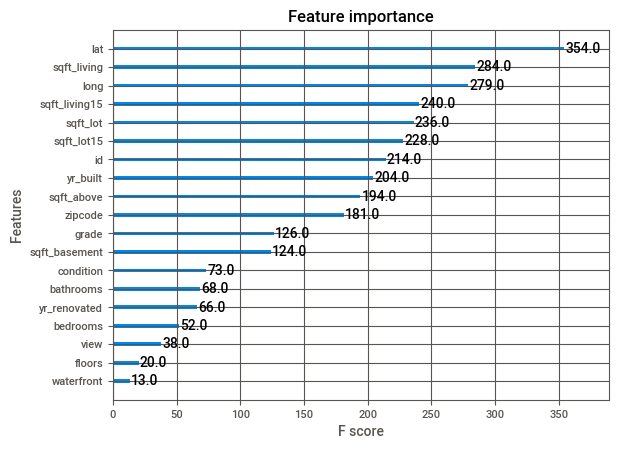

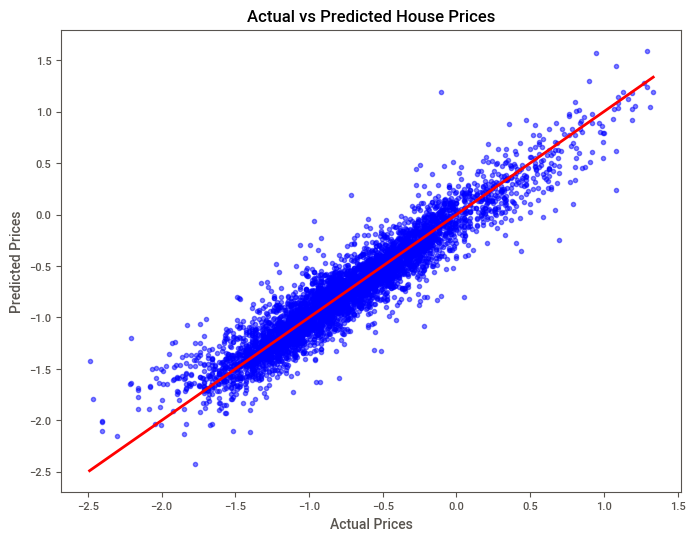

R²: 0.8866898392541196


In [213]:
data_train = xgb.DMatrix(X_train, label=y_train)
data_train.save_binary('train.buffer')

data_test = xgb.DMatrix(X_test, label=y_test)
data_test.save_binary('test.buffer')
param = {'max_depth': 2, 'eta': 1, 'objective': 'reg:squarederror'}
evallist = [(data_train, 'train'), (data_test, 'eval')]
num_round = 1000
bst = xgb.train(param, data_train, num_round, evallist)
bst.save_model('RealEstateXGBosst.json')
xgb.plot_importance(bst)

y_pred = bst.predict(data_test)
print(f"{'Actual':<10}{'Prediction':<10}")
for i in range(10):
    print(f"{y_test.values[i]:<10.4f}{y_pred[i]:<10.4f}")
    

# Plot actual vs predicted values
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)  # Perfect prediction line
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices")
plt.show()

print('R\u00b2: {}'.format(r2_score(y_test, y_pred)))


In [220]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': np.arange(100, 5000, 500),   
    'max_depth': np.arange(3, 10, 1),       
    'learning_rate': np.linspace(0.01, 0.2, 10),  
    'subsample': np.linspace(0.5, 1.0, 5),     
    'colsample_bytree': np.linspace(0.8, 1.0, 4)
}

random_search = RandomizedSearchCV(xgb_model, param_grid, n_iter=50, cv=5, scoring='r2', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

best_model = random_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print(f"Test R² Score: {test_score:.4f}")


/Users/alirezahosseini/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'subsample': 0.625, 'n_estimators': 1600, 'max_depth': 5, 'learning_rate': 0.03111111111111111, 'colsample_bytree': 0.8}
Test R² Score: 0.9119
